Import libraries

In [1]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

# Plotting and tree visualization
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import graphviz

Load csv data

In [2]:
df = pd.read_csv('data.csv')

Prepare features X (hits, QCD/hits, shower width) and target y (Starting station)

In [3]:
X = df.drop(columns=['Starting station'])
y = df['Starting station']

Split train/test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Use RandomizedSearchCV to search parameters within a range per hyperparameters. The goal is to find the best hyperparameters for our model. RandomizedSearchCV trains different models and saves them as variables.

Hyperparameters:
1. n_estimators: number of decision trees in the forest. A high value improves the performance of the model but increases the computational cost of training and predicting.
2. max_depth: maximum depth of each decision tree in the forest. A high value can lead to overfitting; a low value can lead to underfitting.

In [5]:
param_dist = {'n_estimators': randint(50,500), 'max_depth': randint(1,20)}

Create a Random Forest classifier.

In [6]:
rf = RandomForestClassifier()

Search for the best hyperparameters.

In [7]:
rand_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=5, cv=5)

Fit the random search to our data. The output already shows the hyperparameters of the best estimator.

In [8]:
rand_search.fit(X_train, y_train)

,estimator,RandomForestClassifier()
,param_distributions,"{'max_depth': <scipy.stats....x7e83b4275990>, 'n_estimators': <scipy.stats....x7e83b5e20790>}"
,n_iter,5
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


Create a variable for the best model and print its hyperparameters.

In [9]:
best_rf = rand_search.best_estimator_
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 9, 'n_estimators': 111}


Fit the best model found by the RandomizedSearchCV to the data.

In [10]:
best_rf.fit(X_train, y_train)

,n_estimators,111
,criterion,'gini'
,max_depth,9
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Evaluate the model checking the accuracy of the predictions.

In [ ]:
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)


Accuracy:  0.9044943820224719


Use graphviz to visualize the trees. This package uses the format "DOT" as a graph description language. For example, here we visualize the first few nodes of the first few nodes of the first tree. Each node contains three informations:
1. The variable name and the condition used to split the data.
2. The % of samples in each split.
3. The % of samples per class (Starting station) in each split.
The color of each node represents the majority class predicted by that node. Saturated colors mean that the node is purer, whereas faded colors mean that the node is mixed.

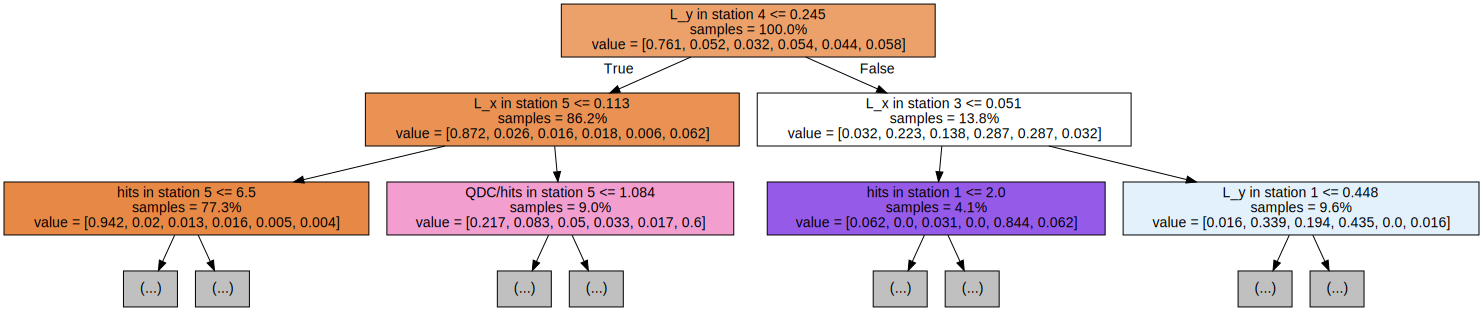

In [12]:
tree = best_rf.estimators_[0]
dot_data = export_graphviz(tree, feature_names=X_train.columns, filled=True, max_depth=2, impurity=False, proportion=True)
graph = graphviz.Source(dot_data)
display(graph)

Plot the Confusion Matrix to compare the true (rows) and predicted (columns) classes. 

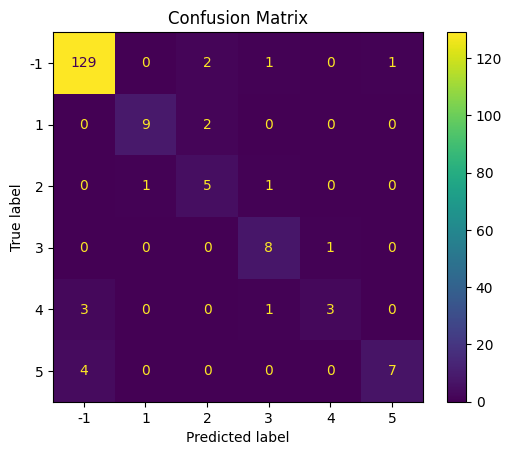

In [13]:
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
display.plot()
plt.title("Confusion Matrix")
plt.show()


Plot the Feature Importance to quantify the usefulness of each feature in the model. A higher score means that the feature contributes more to the accuracy of the classifiication. Note that the importance score on the y axis is relative, not precentage.

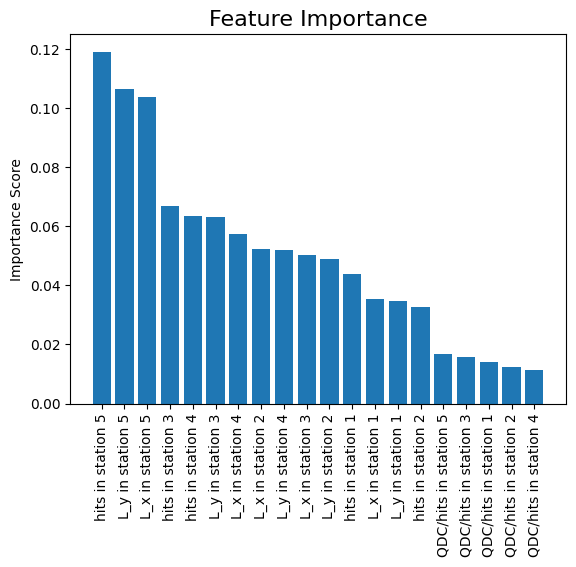

In [15]:
feature_importances = best_rf.feature_importances_
feature_names = X.columns
indices = np.argsort(feature_importances)[::-1]

plt.figure()
plt.title("Feature Importance", fontsize=16)
plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
plt.xticks(range(len(feature_importances)), feature_names[indices], rotation=90)
plt.ylabel("Importance Score")
plt.show()